**Covid Image Classification Project**

**Background and Context**

Covid-19 is a fast-growing disease that affects human health severely. Patients diagnosed with this condition suffer from lung infections. The medical community has recently released vaccines that have a slower effect in increasing immunity. This virus has impacted various countries\' human health and financial standards.

Deep learning algorithms have recently used image classification to identify medical images. Convolutional Neural Networks (CNN) can be widely utilized to identify COVID-19 to assist radiologists in medical analysis by classifying patients who are healthy, have viral pneumonia, or are affected by COVID using X-ray pictures of the lungs.

**Objective**

The aim of this project is two folds:

 - Build a deep learning model  to differentiate an X-ray image of a normal person from an unhealthy one.

- Build an app using Streamlit for users to make predictions or inference using your model.

**Data Description**

This dataset contains training set images of 3 classes which are converted into numpy arrays.

The dataset comprises 3 classes:

- COVID-19: The patient who is affected due to covid.

- Viral Pneumonia: This is a viral fever that has similar characteristics to Covid but is not covid.

- Normal- A healthy Person.

The data file names are:

CovidImages.npy
CovidLabels.csv

Due to the large volume of data, the images were converted to the CovidImages.npy file and the labels are also put into CovidLabels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the image file of dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/CovidImages.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CovidLabels.csv')

**Overview of the dataset**

Let's print the shape of the images and labels

In [4]:
print(images.shape)
print(labels.shape)

(251, 128, 128, 3)
(251, 1)


There are 251 BGR images of shape 128 x 128 X 3 each. As mentioned, each image is an BGR image having 3 channels



**Converting the BGR images to RGB images.**

In [5]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [6]:
np.unique(labels)

array(['Covid', 'Normal', 'Viral Pneumonia'], dtype=object)

**Exploratory Data Analysis**

In [7]:
def plot_images(images,labels):
  # num_classes=10                                                                  # Number of Classes
  # categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
          plt.tight_layout()
  plt.show()

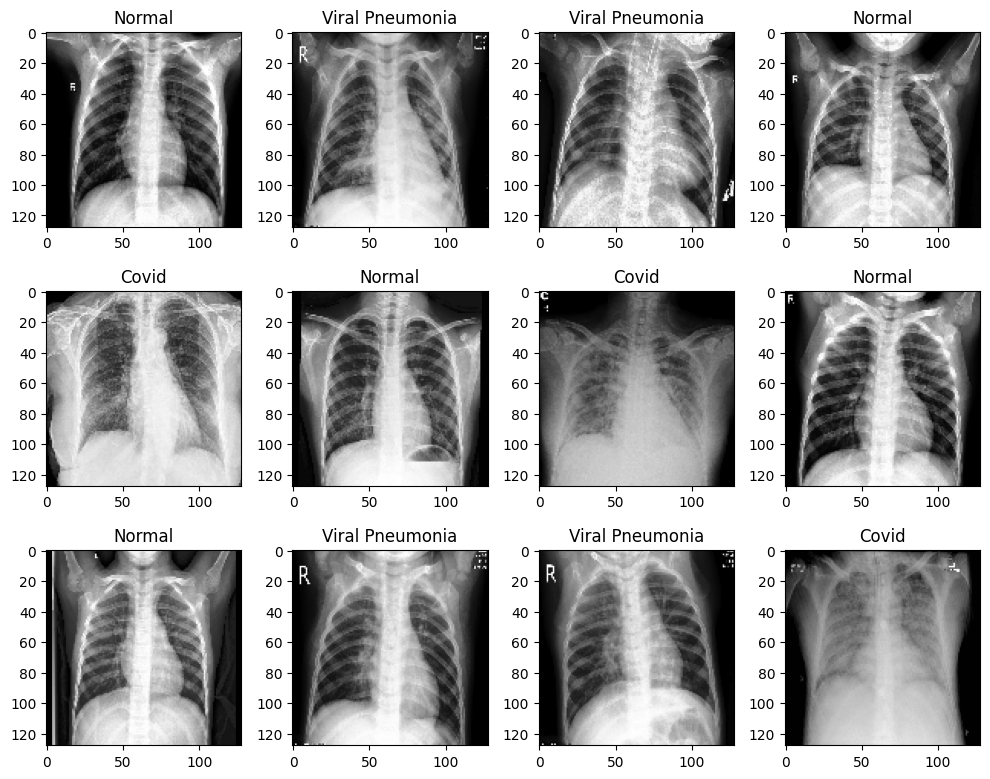

In [8]:
plot_images(images,labels)

**Checking for data imbalance**

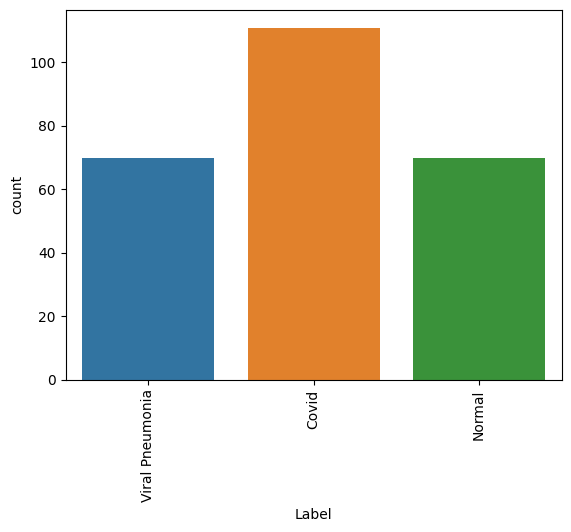

In [9]:
sns.countplot(data = labels, x = "Label")
plt.xticks(rotation=90);

**Splitting the dataset**

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(images),labels , test_size=0.1, random_state=42,stratify=labels)

In [11]:
print(X_train.shape,y_train.shape)

print(X_test.shape,y_test.shape)

(225, 128, 128, 3) (225, 1)
(26, 128, 128, 3) (26, 1)


**Making the data compatible:**

-Convert labels from names to one hot vectors

-Normalizing the values

**Encoding the target labels**

In [12]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

In [14]:
# y_train

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

In [17]:
y_train_enc.shape,y_test_enc.shape

((225, 3), (26, 3))

**Data Normalization**

Since the image pixel values range from 0-255, our method of normalization here will be scaling - we shall divide all the pixel values by 255 to standardize the images to have values between 0-1.

In [18]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

**Model Building - Convolutional Neural Network (CNN)**

Let's create a CNN model sequentially, where we will be adding the layers one after another.

First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's **set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow** to be able to reproduce the same results every time we run the code.

**Transfer Learning using VGG16**

- We will be using the idea of Transfer Learning. We will be loading a pre-built architecture - VGG16, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.

In [19]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [20]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
model_filepath = "/content/drive/MyDrive/Colab Notebooks/vgg_model.h5"
chkpt = ModelCheckpoint(model_filepath, verbose = 1, save_best_only=True)
es = EarlyStopping(patience=3, verbose = 1)

In [22]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (128,128,3))   # Importing the VGG16 Model with pretrained ImageNet weights
vgg_model.summary()                                                                   # Summary of the VGG16 Model without the dense layers

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [23]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [24]:
model = Sequential()

# Adding the convolutional part of the VGG16 model from above
model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model.add(Flatten())

# Adding a dense layer
model.add(Dense(32, activation='relu'))
# Adding droput layer with 0.2 dropout rate
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
# Adding the output layer with 12 neurons
model.add(Dense(3, activation='softmax'))
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
# Epochs
epochs = 10
# Batch size
batch_size = 20
# Fit the model with augmented data
history_vgg16 = model.fit(X_train_normalized,y_train_enc, batch_size=batch_size, shuffle=False,
                          epochs=epochs,
                          validation_split=0.2,
                          verbose=1, callbacks = [es, chkpt])

Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.5056
Epoch 1: val_loss improved from inf to 0.50286, saving model to /content/drive/MyDrive/Colab Notebooks/vgg_model.h5
9/9 [==============================] - 14s 255ms/step - loss: 0.6128 - accuracy: 0.5056 - val_loss: 0.5029 - val_accuracy: 0.6444
Epoch 2/10
9/9 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.7278
Epoch 2: val_loss improved from 0.50286 to 0.40509, saving model to /content/drive/MyDrive/Colab Notebooks/vgg_model.h5
9/9 [==============================] - 1s 77ms/step - loss: 0.4583 - accuracy: 0.7278 - val_loss: 0.4051 - val_accuracy: 0.8222
Epoch 3/10
9/9 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.8667
Epoch 3: val_loss improved from 0.40509 to 0.32916, saving model to /content/drive/MyDrive/Colab Notebooks/vgg_model.h5
9/9 [==============================] - 1s 70ms/step - loss: 0.3324 - accuracy: 0.8667 - val_loss: 0.3292 - val

**Plotting the Epoch vs Accuracy curve**

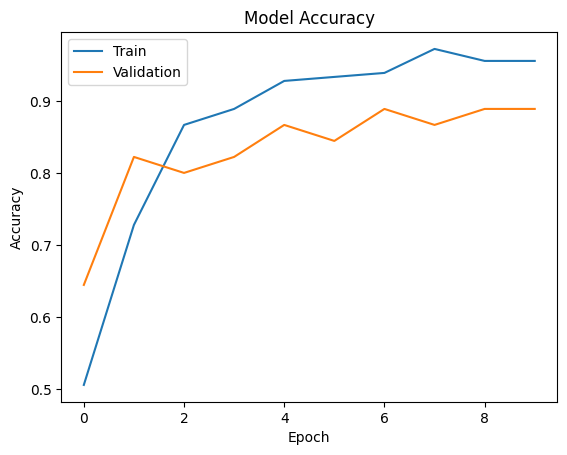

In [26]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Accuracy of the VGG16 Model**

In [27]:
# Getting the accuracy of the model
accuracy = model.evaluate(X_test_normalized, y_test_enc, verbose=2)

1/1 - 2s - loss: 0.0887 - accuracy: 1.0000 - 2s/epoch - 2s/step


In [28]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

1/1 [==============================] - 0s 291ms/step


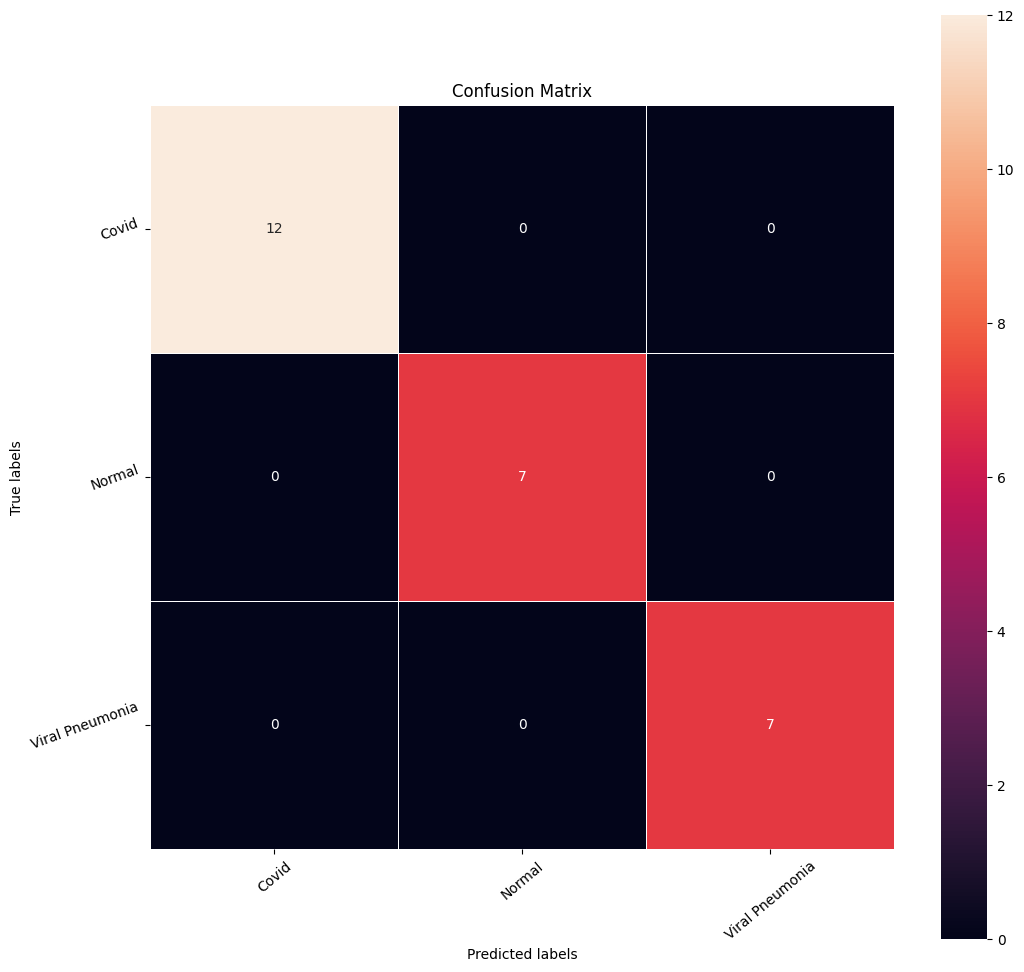

In [29]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_enc,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

**Observations**

- According to the confusion matrix and accuracy curve, the VGG16 model have a perfect performance in predicting the classes of images in the test data .



In [30]:
pd.DataFrame({'Model':['Transfer Learning Model'],'Train Accuracy':['95%'],'Validation Accuracy':['89%'],'Test Accuracy':['100%']})

,Model,Train Accuracy,Validation Accuracy,Test Accuracy
0,Transfer Learning Model,95%,89%,100%
